<a href="https://colab.research.google.com/github/MattRamb97/Erasmus_Hardgainers/blob/main/Recipes_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**RECIPES MODEL**

We utilized the URLs provided to access the datasets stored in the folder https://raw.githubusercontent.com/MattRamb97/Erasmus_Hardgainers/main/Datasets/

using the pandas library. Subsequently, we identified an issue in the 'ingredients' column of the three datasets, characterized by the presence of the word 'ADVERTISEMENT', which we proceeded to remove. Additionally, we printed information regarding one of the datasets (the same information applies to the others) and their respective shapes.

In [1]:
url_1 = 'https://raw.githubusercontent.com/MattRamb97/Erasmus_Hardgainers/main/Datasets/recipes_raw_nosource_ar.json'
url_2 = 'https://raw.githubusercontent.com/MattRamb97/Erasmus_Hardgainers/main/Datasets/recipes_raw_nosource_epi.json'
url_3 = 'https://raw.githubusercontent.com/MattRamb97/Erasmus_Hardgainers/main/Datasets/recipes_raw_nosource_fn.json'

import pandas as pd
df_ar = pd.read_json(url_1, orient='records', dtype='dict').transpose()
df_ar.info()
print()
df_epi = pd.read_json(url_2, orient='records', dtype='dict').transpose()
df_fn = pd.read_json(url_3, orient='records', dtype='dict').transpose()

df_ar['title'] = df_ar['title'].astype(str)
df_epi['title'] = df_epi['title'].astype(str)
df_fn['title'] = df_fn['title'].astype(str)

# Remove the word 'ADVERTISEMENT' from each text entry in the 'ingridients'
df_ar['ingredients'] = df_ar['ingredients'].astype(str).str.replace('ADVERTISEMENT', '',regex=True)
df_epi['ingredients'] = df_epi['ingredients'].astype(str).str.replace('ADVERTISEMENT', '',regex=True)
df_fn['ingredients'] = df_fn['ingredients'].astype(str).str.replace('ADVERTISEMENT', '',regex=True)

df_ar['instructions'] = df_ar['instructions'].astype(str)
df_epi['instructions'] = df_epi['instructions'].astype(str)
df_fn['instructions'] = df_fn['instructions'].astype(str)

print('From AR:', df_ar.shape)
print('From EPI: ', df_epi.shape)
print('FROM FN:', df_fn.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 39802 entries, rmK12Uau.ntP510KeImX506H6Mr6jTu to 2Q3Zpfgt/PUwn1YABjJ5A9T3ZW8xwVa
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         39522 non-null  object
 1   ingredients   39522 non-null  object
 2   instructions  39522 non-null  object
 3   picture_link  39522 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB

From AR: (39802, 4)
From EPI:  (25323, 4)
FROM FN: (60039, 4)


We cleaned the three datasets using two function:
- uncontract(): expands contracted words commonly found in English sentences into their full forms using regular expressions.
- clean_recepies(): removes non-alphanumeric characters from the input text except for spaces and hyphens. It then replaces multiple spaces and hyphens with a single space and normalizes units of measurement (e.g., cups, tablespoons) by removing them. Next, it removes numerical digits, assuming they represent quantities. Finally, it normalizes whitespace by removing extra spaces and ensuring consistent spacing between words.

In [2]:
from tqdm.auto import tqdm
import re

# Basic cleaning apply before the tokenization
def uncontract(text):
    text = re.sub(r"(\b)([Aa]re|[Cc]ould|[Dd]id|[Dd]oes|[Dd]o|[Hh]ad|[Hh]as|[Hh]ave|[Ii]s|[Mm]ight|[Mm]ust|[Ss]hould|[Ww]ere|[Ww]ould)n't", r"\1\2 not", text)
    text = re.sub(r"(\b)([Hh]e|[Ii]|[Ss]he|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'ll", r"\1\2 will", text)
    text = re.sub(r"(\b)([Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'re", r"\1\2 are", text)
    text = re.sub(r"(\b)([Ii]|[Ss]hould|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Ww]ould|[Yy]ou)'ve", r"\1\2 have", text)

    text = re.sub(r"(\b)([Cc]a)n't", r"\1\2n not", text)
    text = re.sub(r"(\b)([Ii])'m", r"\1\2 am", text)
    text = re.sub(r"(\b)([Ll]et)'s", r"\1\2 us", text)
    text = re.sub(r"(\b)([Tt]here)'s", r"\1\2 is", text)
    text = re.sub(r"(\b)([Ww])on't", r"\1\2ill not", text)
    text = re.sub(r"(\b)([Ss])han't", r"\1\2hall not", text)
    text = re.sub(r"(\b)([Yy])(?:'all|a'll)", r"\1\2ou all", text)

    return text

# Specific cleaning for every single tweet
def clean_recepies(text):
     # Remove non-alphanumeric characters except spaces and hyphens
    text = re.sub(r'[^\w\s-]', '', text)

    # Replace multiple spaces and hyphens with a single space
    text = re.sub(r'[-\s]+', ' ', text)

    # Normalize units of measurement (e.g., cups, tablespoons)
    text = re.sub(r'\b(tsp|tbsp|cup|oz|ounce|lb|pound|g|gram|kg|kilogram)\b', '', text, flags=re.IGNORECASE)

    # Remove numbers (assuming they represent quantities)
    text = re.sub(r'\b\d+\b', '', text)

    # Normalize whitespace
    text = ' '.join(text.split())

    return text

# Concatenate titles from all datasets
all_titles = pd.concat([df_ar['title'], df_epi['title'], df_fn['title']], ignore_index=True)
all_ingr = pd.concat([df_ar['ingredients'], df_epi['ingredients'], df_fn['ingredients']], ignore_index=True)
all_inst = pd.concat([df_ar['instructions'], df_epi['instructions'], df_fn['instructions']], ignore_index=True)

# Applying the function uncontract() for basic cleaning
all_titles = [uncontract(t) for t in tqdm(all_titles)]
all_ingr = [uncontract(t) for t in tqdm(all_ingr)]
all_inst = [uncontract(t) for t in tqdm(all_inst)]

# Applying the function clean_tweet() for the tweet specific cleaning
all_titles = [clean_recepies(t) for t in tqdm(all_titles)]
all_ingr = [clean_recepies(t) for t in tqdm(all_ingr)]
all_inst = [clean_recepies(t) for t in tqdm(all_inst)]

  0%|          | 0/125164 [00:00<?, ?it/s]

  0%|          | 0/125164 [00:00<?, ?it/s]

  0%|          | 0/125164 [00:00<?, ?it/s]

  0%|          | 0/125164 [00:00<?, ?it/s]

  0%|          | 0/125164 [00:00<?, ?it/s]

  0%|          | 0/125164 [00:00<?, ?it/s]

In [3]:
!pip install accelerate
!pip install -i https://pypi.org/simple/ bitsandbytes
#!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 2.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

Create a formatting_func to structure training examples as prompts.

In [4]:
def formatting_func(title, ingredients):
    text = f"### Title: {title}\n ### Ingredients: {ingredients}"
    return text
'''
def formatting_func(example):
    text = f"### Title: {example['input']}\n ### Ingredients: {example['output']}"
    return text
'''

'\ndef formatting_func(example):\n    text = f"### Title: {example[\'input\']}\n ### Ingredients: {example[\'output\']}"\n    return text\n'

Load Mistral - mistralai/Mistral-7B-v0.1

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Set up the tokenizer. Add padding on the left as it makes training use less memory. For model_max_length, it's helpful to get a distribution of your data lengths. Let's first tokenize without the truncation/padding, so we can get a length distribution.

In [7]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(title, ingredients):
    return tokenizer(formatting_func(title, ingredients))
'''
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))
'''

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

'\ndef generate_and_tokenize_prompt(prompt):\n    return tokenizer(formatting_func(prompt))\n'

Reformat the prompt and tokenize each sample

In [8]:
tokenized_titles = []
tokenized_ingredients = []

for title, ingredients in zip(df_ar['title'], df_ar['ingredients']):
    tokenized_titles.append(generate_and_tokenize_prompt(title, ingredients))
    tokenized_ingredients.append(generate_and_tokenize_prompt(title, ingredients))

#tokenized_titles = [generate_and_tokenize_prompt(title, ingredients) for title, ingredients in zip(df_ar['title'], df_ar['ingredients'])]

Let's get a distribution of our dataset lengths, so we can determine the appropriate max_length for our input tensors.

79604


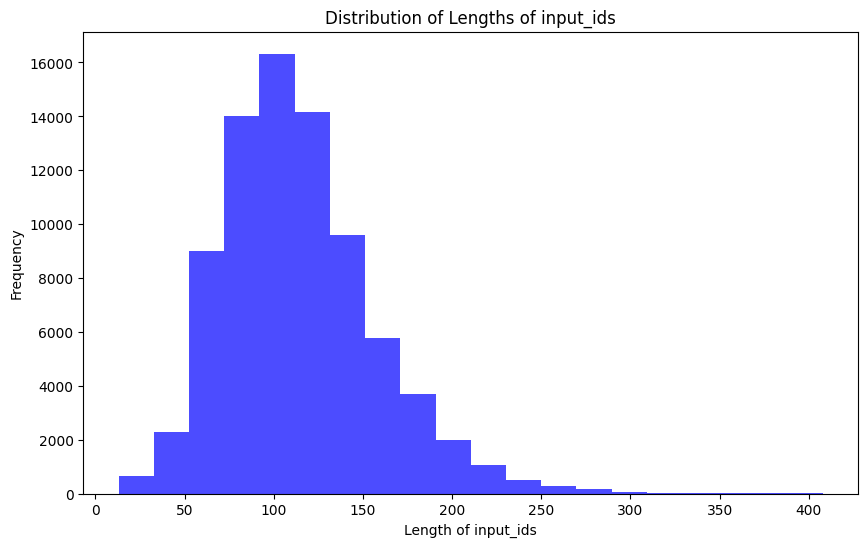

In [9]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_titles, tokenized_ingredients):
    lengths = [len(x['input_ids']) for x in tokenized_titles]
    lengths += [len(x['input_ids']) for x in tokenized_ingredients]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_titles, tokenized_ingredients)

In [10]:
max_length = 150  # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(title, ingredients):
    title_result = tokenizer(
        title,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    ingredients_result = tokenizer(
        ingredients,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )

    title_result["labels"] = title_result["input_ids"].copy()
    ingredients_result["labels"] = ingredients_result["input_ids"].copy()

    return title_result, ingredients_result

tokenized_titles2 = []
tokenized_ingredients2 = []

for title, ingredients in zip(df_ar['title'], df_ar['ingredients']):
    title_result, ingredients_result = generate_and_tokenize_prompt2(title, ingredients)
    tokenized_titles2.append(title_result)
    tokenized_ingredients2.append(ingredients_result)


79604


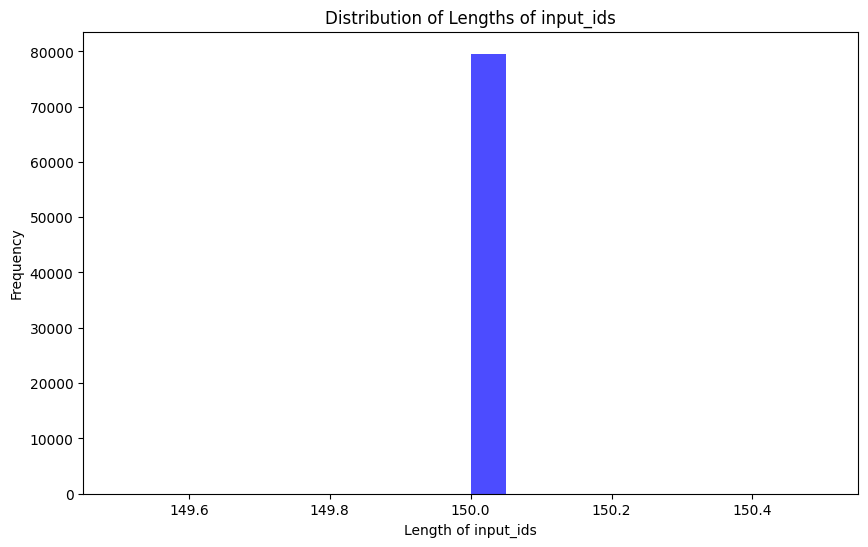

In [11]:
plot_data_lengths(tokenized_titles2, tokenized_ingredients2)

In [12]:
eval_prompt = f"### Title: {title}\n ### Ingredients: {ingredients}"
#eval_prompt = " Title: # Ingredients: # "

# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Title: Super Power Stovetop Granola
 ### Ingredients: ['1/4 cup canola oil ', '3 cups quick-cooking oats ', '3 cups rolled spelt flakes ', '1 cup honey ', '1/2 cup canola oil ', '1/2 teaspoon salt ', '1/4 cup water ', '1 cup raisins ', '1/2 cup chopped almonds ', '1/2 cup flax seed meal ', '1/2 cup hemp seed hearts ', '1/4 cup hemp seeds ', '1/4 cup sunflower seeds ', '']
 ### Category: Breakfast
 ### Time: 60
 ### Servings: 8
 ### Calories: 579.5
 ### Total Fat: 32.5g
 ### Saturated Fat: 2.5g
 ### Cholesterol: 0mg
 ### Sodium: 160.5mg
 ### Carbohydrate: 60.5g
 ### Dietary Fiber: 10.5g
 ### Protein: 14.5g

### Instructions:
In a large bowl, combine the oats and spelt flakes; set aside. In a small saucepan, heat the honey, oil and salt until boiling. Pour over the oat mixture and stir to coat. Spread on two greased baking sheets. Bake at 300° for 20 minutes. Stir in the water. Return to oven and bake for 10 minutes longer or until golden brown. Cool completely. Add remaining ingredi



---



**Set Up LoRA**

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the prepare_model_for_kbit_training method from PEFT.

In [13]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [14]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are q_proj, k_proj, v_proj, o_proj, gate_proj, up_proj, down_proj, and lm_head.

In [15]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

Here we define the LoRA config.

r is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

alpha is the scaling factor for the learned weights. The weight matrix is scaled by alpha/r, and thus a higher value for alpha assigns more weight to the LoRA activations.

The values used in the QLoRA paper were r=64 and lora_alpha=16, and these are said to generalize well, but we will use r=32 and lora_alpha=64 so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [16]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


See how the model looks different now, with the LoRA adapters added:

In [17]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer):



---



**TRAINING LoRA MODEL**

In [18]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [19]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

model = accelerator.prepare_model(model)

In [20]:
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "journal-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import transformers
from datetime import datetime

project = "journal-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_titles,
    eval_dataset=tokenized_ingredients,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        fp16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
